## PPIO Model
### Scaling up LP Problem

Analyze memory/storage and runtime for computing 

Track best objetive function as size of network is scaled up


In [1]:
from PPIO_Model import run_PPIO_model
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm 
import folium
import json
import os
from tqdm import tqdm
from folium import plugins
import gurobipy as gp
import random
import itertools
import math
from gurobipy import GRB
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
class Passenger:
    # Define a passenger object to represent all human passengers traversing the airline network
    def __init__(self, origin, destination):
        self.origin = origin
        self.destination = destination
    def get_origin(self):
        return self.origin
    def get_destination(self):
        return self.destination
    def __repr__(self):
        return f"Passenger traveling from {self.origin} to {self.destination}"
    
# define an object called Flight which consists of a 2-tuple of the route 
# serviced (consisting or origin and destination) airport code and the time t of departure.
class Flight:
    def __init__(self, origin, destination, departure_time, duration=None):
        self.origin = origin
        self.destination = destination
        self.departure_time = departure_time
        self.origin_lat = float(airports_data.loc[airports_data['local_code'] == origin]['latitude_deg'].values)
        self.origin_long = float(airports_data.loc[airports_data['local_code'] == origin]['longitude_deg'].values)
        self.dest_lat = float(airports_data.loc[airports_data['local_code'] == destination]['latitude_deg'].values)
        self.dest_long = float(airports_data.loc[airports_data['local_code'] == destination]['longitude_deg'].values)
        #self.duration = duration or self.get_flight_duration()
        
    def get_origin(self):
        return self.origin

    def get_destination(self):
        return self.destination
        
    def get_departure_time(self):
        return self.departure_time

    def get_fight_duration(self):
        filtrd_data = us_ontime_market[(us_ontime_market['ORIGIN'] == self.origin) & (us_ontime_market['DEST'] == self.destination)]
        flight_duration = int(filtrd_data['ACTUAL_ELAPSED_TIME'].values[0])
        return flight_duration

    def get_arrival_time(self):
        return int(np.ceil(self.get_fight_duration()/60)) + self.departure_time

    def get_distance(self):
        # Radius of the Earth in miles
        earth_radius = 3958.8
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [self.origin_lat, self.origin_long, self.dest_lat, self.dest_long])
        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = earth_radius * c
        distance = us_ontime_market[(us_ontime_market['ORIGIN'] == self.origin) & (us_ontime_market['DEST'] == self.destination)]['DISTANCE']
        return distance 

    def visualize_route(self):
        m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
        folium.Marker(location=[self.origin_lat, self.origin_long], popup=node).add_to(m)
        folium.Marker(location=[self.dest_lat, self.dest_long], popup=node).add_to(m)
        folium.PolyLine([(self.origin_lat, self.origin_long), (self.dest_lat, self.dest_long)], color="blue").add_to(m)
        return m

    def __repr__(self):
        return f"Flight from {self.origin} to {self.destination} departing at t = {self.departure_time}, and arriving at t = {self.get_arrival_time()}"
    
def plane_capacity(planes, mean, std, min_h, max_h):
    '''
    Goal: Return passenger capacities for each unique plane:
            This depends on the type of aircraft, amount of cargo, etc 
            We use a uniform distribution over the supports [min h, max h]   
    Parameters:
        planes: (list) list of planes in operation over the network  (defined as string indices)
        mean: (float) the mean passenger capacity over all planes
        std: (float) the stdev of passenger capacity over all planes
        min_h: (int) the minimum number of passengers allowed on a plane
        max_h: (int) the maximum number of passengers allowed on a plane
    Returns:
        capacity_p: (dict) a dictionary of keys as planes with associated passenger capacity
    ''' 

    # define capacity of each plane
    # src: https://www.faa.gov/sites/faa.gov/files/regulations_policies/policy_guidance/benefit_cost/econ-value-section-3-capacity.pdf  
    capacity_p = {}
    # define distribution for plane capacity 
    # truncated normal distribution  (support: {85, 215}) with mean 150 and stdev 80
    a, b = (min_h - mean) / std, (max_h - mean) / std
    for i in planes:
        capacity_p[i] = int(truncnorm.rvs(a, b, loc = mean, scale = std, size=1))
    return capacity_p

def airport_capacity(airports, mean, std, min_a, max_a):
    '''
    Goal: Return planes capacities for each unique airport:
            This depends on the type of airport, amount of cargo, etc 
            We use a uniform distribution over the supports [min a, max a]   
    Parameters:
        airports: (list) list of airports in operation over the network  (defined as string indices)
        mean: (float) the mean plane capacity over all airports
        std: (float) the stdev of plane capacity over all airports
        min_a: (int) the minimum number of planes allowed on a plane
        max_a: (int) the maximum number of planes allowed on a plane
    Returns:
        capacity_a: (dict) a dictionary of keys as airports with associated plane capacity
    '''
    # define capacity of each airport
    capacity_a = {}
    # define distribution for airport capacity 
    # truncated normal distribution  (support: {1, 5}) with mean and stdev
    a, b = (min_a - mean) / std, (max_a - mean) / std
    for i in airports:
        capacity_a[i] = int(truncnorm.rvs(a, b, loc = mean, scale = std, size=1))
    return capacity_a

def create_complete_network(airports):
    '''
    Goal: given a set of airports to serve as nodes of the graph, return a complete airline network topology
    Parameters:
        airports (list): list of airports in the network
    Return:
        G_complete (networkx graph): the complete graph of the airline network topology
    '''
    # consider a complete graph (all possible options)
    G_complete = nx.complete_graph(airports) # we select flights (t + route(i,j)) to operate these   (a flight object is later defined)
    coords = {}
    for i in G_complete.nodes:
        origin_lat = float(airports_data.loc[airports_data['local_code'] == i]['latitude_deg'].values)
        origin_long = float(airports_data.loc[airports_data['local_code'] == i]['longitude_deg'].values)
        coords[i] = (origin_lat, origin_long)
    nx.set_node_attributes(G_complete, coords, name = 'pos')
    G_complete = G_complete.to_directed()
    return G_complete

import random
import itertools
import networkx as nx

def sample_routes(set_of_airports, total_edges):
    '''
    Goal: generate a random subset of directed edges/routes from the complete graph
    Parameters:
        set_of_airports (list): a list of airports in the airline network topology
        total_edges (int): number of routes to sample from complete graph
    Return:
        sampled_routes (list): list of viable routes in the network such that a path exists between all airports
    '''
    def is_connected(random_routes):
        permutations_of_routes = list(itertools.permutations(set_of_airports, 2))
        # ensure the random routes generated forms a connected graph!
        G_check = nx.DiGraph()
        # Add edges from the list of tuples
        G_check.add_edges_from(random_routes)

        for pair in permutations_of_routes:
            if not nx.has_path(G_check, pair[0], pair[1]):   
                return False
        return True

    permutations_of_routes = list(itertools.permutations(set_of_airports, 2))

    while True:
        try:
            sampled_routes = random.sample(permutations_of_routes, total_edges)
            if is_connected(sampled_routes):
                return sampled_routes
        except nx.NodeNotFound:
            # Catch the NodeNotFound error and continue the loop to sample new routes
            pass

# DATA: airports IATA Code and Geographical Coordinates
airports_data = pd.read_csv('Data/us-airports.csv')
airports_data = airports_data[['latitude_deg','longitude_deg','local_code']]
airports_data = airports_data.iloc[1:]

# DATA: on time preformance by airlines between two airports : extract distance and duration
us_ontime_market = pd.read_csv('Data/T_ONTIME_MARKETING.csv')
us_ontime_market = us_ontime_market.groupby(['ORIGIN', 'DEST'])[['ACTUAL_ELAPSED_TIME', 'DISTANCE']].mean().reset_index()

In [3]:
def generate_data(T, set_of_airports, d, P, H):
    # number of possible routes d, number of operational planes p
    # number of passengers H

    N = len(set_of_airports)

    if N*(N-1) < d:
        return "Error: max possible routes reached"

    # define possible routes
    routes = sample_routes(set_of_airports, d)
    # note down all possible routes (direction included)
    permutations_of_routes = list(itertools.permutations(set_of_airports, 2))

    # define the set of planes and P number of planes to use
    planes_p = {}
    for x in range(P):
        planes_p[f"p_{x}"] = random.sample(set_of_airports, 1)[0]  # select random airport to be plane's base


    passengers_h = {}
    for i in range(H):
        # define a random origin and final destination airport for each passenger
        origin_h, dest_h = random.sample(permutations_of_routes, 1)[0]
        passengers_h[f'''h_{i}'''] = Passenger(origin_h, dest_h)

    # define flights given all possible routes and time t
    # define all possible flights: this is dependent on the time AND route 
    flights = {}
    counter = 1
    for i in routes:
        for t in T:
            name = f'''f_{counter}'''
            org, dest = i
            flight_obj = Flight(origin=org, destination=dest, departure_time=t)
            flights[name] = (flight_obj.get_origin(), flight_obj.get_destination(), flight_obj.get_departure_time(), flight_obj.get_arrival_time())
            counter += 1

    return routes, T, passengers_h, set_of_airports, planes_p

### Analysis I: Scale up number of passengers traversing the network 

- Fix the airline network topology as passenger set varies
- Store best objective function, model eval time
- Compare different sized network topologies 

In [6]:
## Consider an airline network topology consisting of 5 airports 
airports_1 =['EWR','ORD','LAS','LAX', 'DFW', 'CLT']
T = np.arange(0, 50, 1)
d = 20
P = 25
H = 100

routes1, T1, passengers1, airports1, planes1 = generate_data(T, airports_1, d, P, H)

In [9]:
gp_model_2, X, W, Z, Y = run_PPIO_model(routes1, T1, passengers1, airports1, planes1) 

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21442050 rows, 162500 columns and 43748750 nonzeros
Model fingerprint: 0xcf718173
Variable types: 0 continuous, 162500 integer (162500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve removed 300 rows and 0 columns (presolve time = 11s) ...
Presolve removed 3185318 rows and 21523 columns (presolve time = 15s) ...
Presolve removed 5943362 rows and 36407 columns (presolve time = 20s) ...
Presolve removed 6204194 rows and 36673 columns (presolve time = 25s) ...
Presolve removed 1375697

In [8]:
gp_model, X, W, Z, Y = run_PPIO_model(routes1, T1, passengers1, airports1, planes1, second_objective=False) 

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21442150 rows, 162600 columns and 43758850 nonzeros
Model fingerprint: 0xd5d96c50
Variable types: 100 continuous, 162500 integer (162500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 0 columns (presolve time = 8s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 1090 rows and 250 columns (presolve time = 15s) ...
Presolve removed 3185318 rows and 21523 columns (presolve time = 20s) ...
Presolve removed 5225006 rows and 36407 columns (presolve time = 25s) ...
Presolve removed 6204194 rows

In [13]:
# compare the objective functions and runtime
# the objective function with 
print(gp_model_2.ObjVal, gp_model_2.runtime)

print(50*100 - gp_model.ObjVal, gp_model.runtime)  

4319.0 302.1749999523163
4319.0 411.73799991607666


Compare Objective Function Values and Optimal Solutions given the two OBJ FUNCTIONS

Same objective function is reached with the same optimal set of solution decision variables. Runtime/Optimization solver time is larger for the minimization obj func

In [16]:
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm


# fix the airports set 
airports = ['JFK', 'LAS', 'MCO']
T = np.arange(0,24,1)
d = 4
P = 2
number_h = [3,5,8,10,12,15,20,25]


avg_obj_fun = []
LP_runtimes = []

for i in tqdm(number_h):
    routes1, T1, passengers1, airports1, planes1 = generate_data(T, airports, d, P, i)
    gp_model, X, W, Z, Y = run_PPIO_model(routes1, T1, passengers1, airports1, planes1) 

    try:
        gp_model.optimize()

        # Check optimization status
        if gp_model.status == GRB.Status.INFEASIBLE:
            print(f"Instance {i}: The problem is infeasible.")
            avg_obj_fun.append(0)  # Set the objective value to 0 for infeasible instances
            LP_runtimes.append(gp_model.runtime)
        else:
            avg_obj = ( i*len(T) - gp_model.objVal ) / i
            print(f"Instance {i}: Optimal objective function value:", avg_obj)
            avg_obj_fun.append(avg_obj)
            LP_runtimes.append(gp_model.runtime)

    except gp.GurobiError as e:
        print(f"Instance {i}: Gurobi error: {e}")
        # Handle the error as needed, e.g., logging or displaying an error message
        avg_obj_fun.append(0)  # Set the objective value to 0 for error instances
        LP_runtimes.append(0)  # Set the runtime to 0 for error instances

    except AttributeError:
        print(f"Instance {i}: Unable to retrieve attribute 'objval'. Setting objective value to 0.")
        avg_obj_fun.append(0)  # Set the objective value to 0 for instances with attribute error
        LP_runtimes.append(0)  # Set the runtime to 0 for instances with attribute error


  0%|          | 0/8 [00:00<?, ?it/s]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16943 rows, 840 columns and 36939 nonzeros
Model fingerprint: 0xc22792ef
Variable types: 0 continuous, 840 integer (840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 16642 rows and 604 columns
Presolve time: 0.08s

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.03 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM)

 12%|█▎        | 1/8 [00:04<00:29,  4.25s/it]

Instance 3: The problem is infeasible.
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25837 rows, 1176 columns and 56284 nonzeros
Model fingerprint: 0x44ef3bb0
Variable types: 0 continuous, 1176 integer (1176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 25677 rows and 1021 columns
Presolve time: 0.16s
Presolved: 160 rows, 155 columns, 772 nonzeros
Variable types: 0 continuous, 155 integer (155 binary)
Found heuristic solution: objective 76.0000000

Root relaxation: objective 8.600000e+01, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

 25%|██▌       | 2/8 [00:09<00:27,  4.55s/it]

Instance 5: Optimal objective function value: 6.8
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36838 rows, 1680 columns and 80344 nonzeros
Model fingerprint: 0x671b7d58
Variable types: 0 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 36795 rows and 1621 columns
Presolve time: 0.15s
Presolved: 43 rows, 59 columns, 167 nonzeros
Variable types: 0 continuous, 59 integer (59 binary)
Found heuristic solution: objective 116.0000000

Root relaxation: cutoff, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bo

 38%|███▊      | 3/8 [00:14<00:24,  4.95s/it]

Instance 8: Optimal objective function value: 9.5
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 45900 rows, 2016 columns and 100044 nonzeros
Model fingerprint: 0xb7607629
Variable types: 0 continuous, 2016 integer (2016 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 45388 rows and 1598 columns
Presolve time: 0.16s

Explored 0 nodes (0 simplex iterations) in 0.19 seconds (0.07 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 10.0.3

 50%|█████     | 4/8 [00:19<00:20,  5.04s/it]

Instance 10: The problem is infeasible.
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 47138 rows, 2352 columns and 103170 nonzeros
Model fingerprint: 0xf127d9cd
Variable types: 0 continuous, 2352 integer (2352 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 46669 rows and 2043 columns
Presolve time: 0.19s
Presolved: 469 rows, 309 columns, 2046 nonzeros
Variable types: 0 continuous, 309 integer (309 binary)
Found heuristic solution: objective 189.0000000

Root relaxation: objective 1.990000e+02, 224 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |    

 62%|██████▎   | 5/8 [00:25<00:15,  5.23s/it]

Instance 12: Optimal objective function value: 7.75
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 62507 rows, 2856 columns and 136484 nonzeros
Model fingerprint: 0xd1c9eaac
Variable types: 0 continuous, 2856 integer (2856 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 62319 rows and 2669 columns
Presolve time: 0.29s
Presolved: 188 rows, 187 columns, 806 nonzeros
Variable types: 0 continuous, 187 integer (187 binary)
Found heuristic solution: objective 213.0000000
Found heuristic solution: objective 217.0000000

Root relaxation: cutoff, 112 iterations, 0.00 seconds (0.00 work unit

 75%|███████▌  | 6/8 [00:31<00:11,  5.56s/it]

Instance 15: Optimal objective function value: 9.533333333333333
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 73978 rows, 3696 columns and 162042 nonzeros
Model fingerprint: 0xb8f775da
Variable types: 0 continuous, 3696 integer (3696 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 73259 rows and 3237 columns
Presolve time: 0.58s
Presolved: 719 rows, 459 columns, 3142 nonzeros
Variable types: 0 continuous, 459 integer (459 binary)
Found heuristic solution: objective 315.0000000

Root relaxation: objective 3.250000e+02, 355 iterations, 0.02 seconds (0.00 work units)

    Nodes    |

 88%|████████▊ | 7/8 [00:40<00:06,  6.61s/it]

Instance 20: Optimal objective function value: 7.95
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 90753 rows, 4536 columns and 198837 nonzeros
Model fingerprint: 0x88747204
Variable types: 0 continuous, 4536 integer (4536 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 89689 rows and 3780 columns
Presolve time: 0.25s

Explored 0 nodes (0 simplex iterations) in 0.30 seconds (0.15 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 10.0

100%|██████████| 8/8 [00:47<00:00,  5.94s/it]

Instance 25: The problem is infeasible.


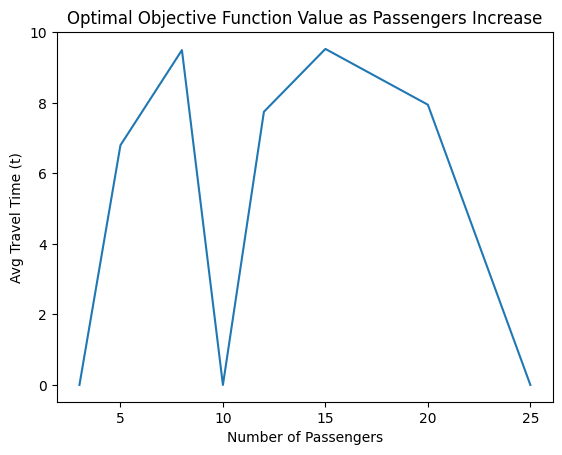

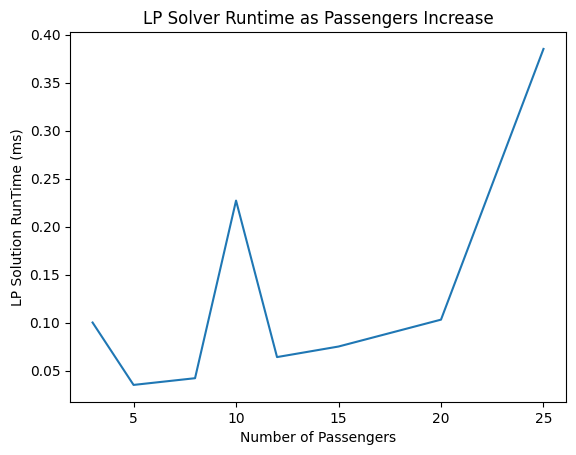

In [19]:
plt.plot(number_h, avg_obj_fun)
plt.ylabel('Avg Travel Time (t)')
plt.xlabel('Number of Passengers')
plt.title('Optimal Objective Function Value as Passengers Increase')
plt.show()


plt.plot(number_h, LP_runtimes)
plt.ylabel('LP Solution RunTime (ms)')
plt.xlabel('Number of Passengers')
plt.title('LP Solver Runtime as Passengers Increase')
plt.show()

### Analysis II: Scale up number of operational planes traversing the network 

- Fix the airline network topology as plane count set varies
- Store best objective function, model eval time
- Determine the min number of required planes as number of passengers increase

In [23]:
def get_min_req_planes(number_h):
    # fix the airports set 
    airports = ['JFK', 'LAS', 'MCO']
    T = np.arange(0,24,1)
    d = 4
    P = [1,2,3,4,5,6,7,8,9,10,11,12]

    for i in (P):
        routes1, T1, passengers1, airports1, planes1 = generate_data(T, airports, d, i, number_h)
        gp_model, X, W, Z, Y = run_PPIO_model(routes1, T1, passengers1, airports1, planes1) 

        if gp_model.status == GRB.Status.INFEASIBLE:
            pass
        else:
            objfunc = gp_model.objVal
            runtime = gp_model.runtime
            optimal_p = i
            return objfunc, runtime, optimal_p

In [24]:
passenger_count = [4,6,8,10,12,15,18,20,25,30,35,40,50,60]
optimal_func_val = []
solver_runtime = []
optimal_num_p = []

for j in tqdm(passenger_count):
    obj, rt, plane = get_min_req_planes(j)
    optimal_func_val.append(obj)
    solver_runtime.append(rt)
    optimal_num_p.append(plane)

  0%|          | 0/14 [00:00<?, ?it/s]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16943 rows, 840 columns and 36867 nonzeros
Model fingerprint: 0x2d28a331
Variable types: 0 continuous, 840 integer (840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 14519 rows and 638 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gurobi O

  7%|▋         | 1/14 [00:08<01:44,  8.05s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 29029 rows, 1176 columns and 62974 nonzeros
Model fingerprint: 0x76bdbf7a
Variable types: 0 continuous, 1176 integer (1176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 28624 rows and 838 columns
Presolve time: 0.06s

Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.03 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gurob

 14%|█▍        | 2/14 [00:18<01:51,  9.27s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30363 rows, 1512 columns and 66303 nonzeros
Model fingerprint: 0x8a3d351e
Variable types: 0 continuous, 1512 integer (1512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 29883 rows and 1059 columns
Presolve time: 0.11s

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.05 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Guro

 21%|██▏       | 3/14 [00:32<02:07, 11.57s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 37073 rows, 1848 columns and 81021 nonzeros
Model fingerprint: 0x1248ffdd
Variable types: 0 continuous, 1848 integer (1848 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 36516 rows and 1309 columns
Presolve time: 0.13s

Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.06 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Guro

 29%|██▊       | 4/14 [00:50<02:23, 14.30s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 43783 rows, 2184 columns and 95739 nonzeros
Model fingerprint: 0xf3d2ff33
Variable types: 0 continuous, 2184 integer (2184 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 34247 rows and 1357 columns
Presolve time: 0.07s

Explored 0 nodes (0 simplex iterations) in 0.17 seconds (0.03 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Guro

 36%|███▌      | 5/14 [01:07<02:16, 15.11s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 61144 rows, 2688 columns and 133272 nonzeros
Model fingerprint: 0xcfa47157
Variable types: 0 continuous, 2688 integer (2688 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 52129 rows and 1801 columns
Presolve time: 0.08s

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.04 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gur

 43%|████▎     | 6/14 [01:21<01:57, 14.75s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 69841 rows, 3192 columns and 152452 nonzeros
Model fingerprint: 0x66ee09fb
Variable types: 0 continuous, 3192 integer (3192 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 69151 rows and 2590 columns
Presolve time: 0.25s

Explored 0 nodes (0 simplex iterations) in 0.33 seconds (0.10 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gur

 50%|█████     | 7/14 [01:52<02:19, 19.92s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 77175 rows, 3528 columns and 168492 nonzeros
Model fingerprint: 0x312975a9
Variable types: 0 continuous, 3528 integer (3528 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 75867 rows and 2249 columns
Presolve time: 0.16s

Explored 0 nodes (0 simplex iterations) in 0.24 seconds (0.08 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gur

 57%|█████▋    | 8/14 [02:25<02:25, 24.18s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 87398 rows, 4368 columns and 191406 nonzeros
Model fingerprint: 0x0a6a6054
Variable types: 0 continuous, 4368 integer (4368 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 68570 rows and 2837 columns
Presolve time: 0.09s

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.07 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
Gur

 64%|██████▍   | 9/14 [02:42<01:49, 21.88s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 118309 rows, 5208 columns and 258147 nonzeros
Model fingerprint: 0x68935d3d
Variable types: 0 continuous, 5208 integer (5208 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 108073 rows and 3862 columns
Presolve time: 0.17s

Explored 0 nodes (0 simplex iterations) in 0.29 seconds (0.09 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
G

 71%|███████▏  | 10/14 [03:11<01:36, 24.08s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 137364 rows, 6048 columns and 299772 nonzeros
Model fingerprint: 0x29944abb
Variable types: 0 continuous, 6048 integer (6048 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 125775 rows and 4491 columns
Presolve time: 0.18s

Explored 0 nodes (0 simplex iterations) in 0.33 seconds (0.11 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
G

 79%|███████▊  | 11/14 [03:39<01:15, 25.23s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 156419 rows, 6888 columns and 341397 nonzeros
Model fingerprint: 0x912e4f04
Variable types: 0 continuous, 6888 integer (6888 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 154998 rows and 5303 columns
Presolve time: 0.64s

Explored 0 nodes (0 simplex iterations) in 0.81 seconds (0.27 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
G

 86%|████████▌ | 12/14 [04:09<00:53, 26.79s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 194529 rows, 8568 columns and 424647 nonzeros
Model fingerprint: 0x6214677e
Variable types: 0 continuous, 8568 integer (8568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 179647 rows and 6526 columns
Presolve time: 0.23s

Explored 0 nodes (0 simplex iterations) in 0.41 seconds (0.16 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraints
G

 93%|█████████▎| 13/14 [04:44<00:29, 29.24s/it]

Model Updated with Core Objective Function
Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 204823 rows, 10248 columns and 448971 nonzeros
Model fingerprint: 0x654d768c
Variable types: 0 continuous, 10248 integer (10248 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 201877 rows and 7159 columns
Presolve time: 1.44s

Explored 0 nodes (0 simplex iterations) in 1.71 seconds (0.40 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Model Updated with Core Objective Function
Model updated with all constraint

100%|██████████| 14/14 [06:09<00:00, 26.43s/it]


In [ ]:
passenger_count = [4,6,8,10,12,15,18,20,25,30,35,40,50,60]
optimal_func_val = []
solver_runtime = []
optimal_num_p = []

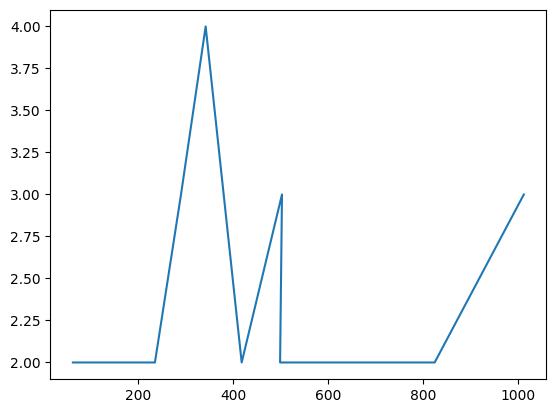

In [29]:
plt.plot(optimal_func_val, optimal_num_p)

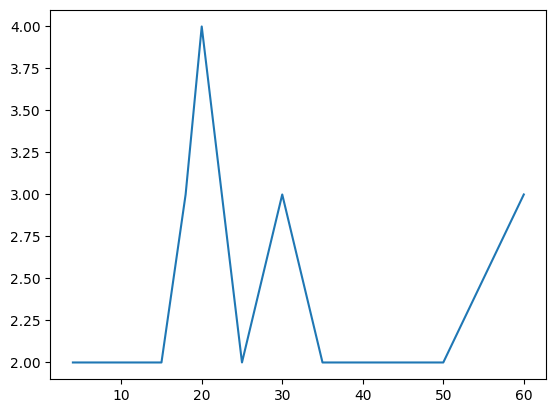

In [27]:
# plot passengers against optiaml func val
plt.plot(passenger_count, optimal_num_p)  # recall here that the larger the value, the better 